In [17]:
import numpy as np
import json

from ahyper import utils, annotated_hypergraph, observables
from matplotlib import pyplot as plt
import matplotlib.patches as patches

import pandas as pd

import numpy as np
import networkx as nx

In [18]:
with open('data/enron_hypergraph_annotated.json') as file:
    data = json.load(file)

roles = ['cc', 'from', 'to']

A = annotated_hypergraph.AnnotatedHypergraph.from_records(data, roles)
A.remove_degeneracies(precedence = {'from' : 1, 'to' : 2, 'cc' : 3})
A.remove_singletons()

Removed 1246 node-edge incidences
Removed 901 singletons.


In [19]:
def get_partition(R, k, n_reps):

    A.assign_role_interaction_matrix(R)
    
    W_ = A.null_expectation_matrix()
    W = A.to_weighted_projection(as_matrix = True)

    # symmetrize
    Ws =  (W  + W.T) / 2
    Ws_ = (W_ + W_.T)/2

    best_Q = 0
    for i in range(n_reps):
        ell, Q = observables.multiway_spectral(Ws, Ws_, k)
        if Q > best_Q:
            best_Q = Q
            best_part = ell

    Q = best_Q
    ell = best_part
    return(Q, ell)

# Case Study + Viz

In [20]:
A.roles

['cc', 'from', 'to']

In [21]:
np.random.seed(555)


R = np.array([[0.0, 0.0, 0.0], 
              [0.25, 0.0, 1.0], 
              [0.0, 0.0, 0.0]])

Q, ell = get_partition(R, 4, 100)

print(Q)

0.5061295596570673


In [26]:
def reorder_labels(x):
    counts = np.bincount(x)
    lookup = np.argsort(np.argsort(-counts))
    return(np.array([lookup[i] for i in x]).astype(int))

ell = -reorder_labels(ell.astype(int))


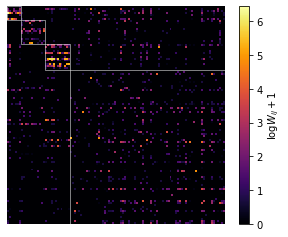

In [47]:

def degree_sort(A, d):
    row_sorted = A[np.argsort(d)]
    col_sorted = row_sorted[:, np.argsort(d)]
    return(col_sorted)

W = A.to_weighted_projection(as_matrix = True)

fig = plt.figure(figsize = (5, 4))
ax = fig.add_subplot(111)
im = ax.imshow(degree_sort(np.log(1+W), ell), cmap = 'inferno', interpolation = 'nearest')

ix1 = np.array([0,0])

for i in np.unique(ell):
    j = (ell == i).sum()
    rect = patches.Rectangle(ix1-.5,j,j,linewidth=.5,edgecolor='w',facecolor='none')
    ax.add_patch(rect)
    ix1 += np.array([j,j])

for loc in ['top', 'right', 'bottom', 'left']:
        ax.spines[loc].set_visible(False)

ax.tick_params(
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    right=False,
    left=False,
    labelbottom=False,
    labelleft=False,
    length = 0)
    
cbar = plt.colorbar(im)
cbar.ax.set_ylabel(r'$\log W_{ij} + 1$', rotation = 90)

plt.savefig('fig/partition_matrix.png', dpi = 300)

In [7]:
t = 0

threshed = W.copy()
threshed[threshed < t] = 0

H = nx.from_numpy_array(W, create_using = nx.DiGraph())
G = nx.from_numpy_array(threshed,create_using = nx.DiGraph())

isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)

nx.set_node_attributes(G, 
                      {i : ell[i] for i in G.nodes},
                      'group')

In [8]:
# labels = pd.read_csv('data/enron_jobs.csv')
# labels['job'] = labels.job.astype(str)
# lookup_ = {labels.node_id.iloc[i] : labels.job.iloc[i] for i in range(len(labels))}
# lookup = {key : lookup_[key] for key in lookup_ if lookup_[key] != 'nan'}

# to_rm = []
# for j in lookup:
#     if j not in G.nodes:
#         to_rm.append(j)
        
# # for j in to_rm:
# #     lookup.pop(j)
    
# nx.set_node_attributes(G, lookup, 'label')

# # groups = [nx.get_node_attributes(G, 'group')[i] for i in G.nodes]

# groups = np.array(list(nx.get_node_attributes(G, 'group')[i] for i in G.nodes))
# ids = np.array(list(G.nodes))
# new_ids = groups * 1000 + ids

# mapper = {ids[i] : new_ids[i] for i in range(len(G.nodes))}

# G = nx.relabel_nodes(G, mapper)

In [10]:
edges = nx.to_pandas_edgelist(G)
nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index').reset_index()
labels = pd.read_csv('data/enron_jobs.csv')

nodes = nodes.merge(labels, 'left', left_on = 'index', right_on = 'node_id')

nodes.to_csv('throughput/nodes.csv', index = False)
edges.to_csv('throughput/edges.csv', index = False)

# Batch Comparisons

In [50]:
np.random.seed(1)

Q, ell = get_partition(R, 4, 100)
print(Q, len(np.unique(ell)))

0.5059156107430579 4


In [51]:
R1 = np.ones((3,3))

In [52]:
np.random.seed(1)

Q1, ell1 = get_partition(R1, 4, 100)
print(Q1, len(np.unique(ell1)))

0.5242707816136633 3


In [53]:
observables.MI(ell, ell1, normalize=True)

/Users/philchodrow/Dropbox (MIT)/projects/annotated_hypergraphs_code/ahyper/observables.py:435: RuntimeWarning: invalid value encountered in true_divide
  mat = (joint*np.log(joint / np.outer(p_x, p_y)))
/Users/philchodrow/Dropbox (MIT)/projects/annotated_hypergraphs_code/ahyper/observables.py:435: RuntimeWarning: divide by zero encountered in log
  mat = (joint*np.log(joint / np.outer(p_x, p_y)))
/Users/philchodrow/Dropbox (MIT)/projects/annotated_hypergraphs_code/ahyper/observables.py:435: RuntimeWarning: invalid value encountered in multiply
  mat = (joint*np.log(joint / np.outer(p_x, p_y)))
/Users/philchodrow/Dropbox (MIT)/projects/annotated_hypergraphs_code/ahyper/observables.py:445: RuntimeWarning: divide by zero encountered in log
  H_y = -p_y*np.log(p_y)
/Users/philchodrow/Dropbox (MIT)/projects/annotated_hypergraphs_code/ahyper/observables.py:445: RuntimeWarning: invalid value encountered in multiply
  H_y = -p_y*np.log(p_y)


0.5526933071363485